In [0]:
import os
import zipfile
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [0]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import numpy as np
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from skimage import io, transform

In [3]:
from google.colab import files
files.upload()

Saving genre_small.csv to genre_small.csv


{'genre_small.csv': b',track\r\n,genre_top\r\ntrack_id,\r\n2,Hip-Hop\r\n5,Hip-Hop\r\n10,Pop\r\n140,Folk\r\n141,Folk\r\n148,Experimental\r\n182,Rock\r\n190,Folk\r\n193,Folk\r\n194,Folk\r\n197,Folk\r\n200,Folk\r\n203,Folk\r\n204,Folk\r\n207,Folk\r\n210,Folk\r\n211,Folk\r\n212,Folk\r\n213,Pop\r\n255,Rock\r\n256,Rock\r\n368,Rock\r\n424,Experimental\r\n459,Rock\r\n534,Folk\r\n540,Folk\r\n546,Folk\r\n574,Rock\r\n602,Folk\r\n615,Experimental\r\n620,Folk\r\n621,Folk\r\n625,Folk\r\n666,International\r\n667,International\r\n676,Hip-Hop\r\n690,Rock\r\n694,Hip-Hop\r\n695,Hip-Hop\r\n704,International\r\n705,International\r\n706,International\r\n707,International\r\n708,International\r\n709,International\r\n714,Folk\r\n715,Folk\r\n716,Folk\r\n718,Folk\r\n777,Rock\r\n814,Folk\r\n821,Pop\r\n822,Pop\r\n825,Rock\r\n853,International\r\n890,Folk\r\n892,Folk\r\n897,Experimental\r\n993,Rock\r\n995,Experimental\r\n997,Experimental\r\n998,Experimental\r\n1039,Rock\r\n1040,Rock\r\n1066,Experimental\r\n1069,Ex

In [0]:
import pandas as pd
track = pd.read_csv('./genre_small.csv')

In [0]:
y = track.iloc[:,1:2].values
ID = track.iloc[:,0:1].values
y = y[2:,:]
ID = ID[2:,:]

label = {}
for i,j in zip(ID,y):
  label[str(i[0])] = j[0]

In [12]:
print(label['100478'])

Hip-Hop


In [8]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='19MxOn5NsxMccFIQwqukrzpJN2nNaXX_M',
                                    dest_path='./fma_spec.zip')

In [0]:
zip_ref = zipfile.ZipFile('./fma_spec.zip', 'r')
zip_ref.extractall(os.getcwd())
zip_ref.close()

In [0]:
img_dir = os.listdir('./fma_spec')

In [0]:
%rm fma_spec.zip

In [0]:
!ls fma_spec

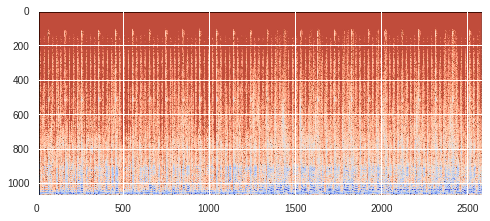

In [14]:
temp = cv2.imread('/content/fma_spec/100478.jpg')
plt.imshow(temp)

In [0]:
def chop_image(path):
  img = cv2.imread(path)
  height, width, channels = img.shape
  
  w = width // 10

  images = []

  for i in range(0,10):
    temp = img[:, (i*w):((i+1)*w), :]
    temp = cv2.resize(temp,(224,224))
    images.append(temp)
  return images

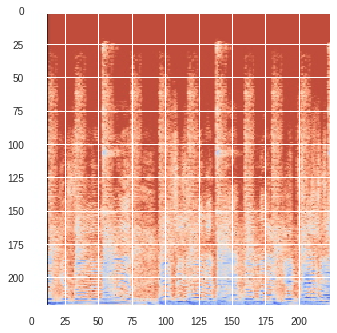

In [36]:
temp = chop_image('/content/fma_spec/100478.jpg')
#print(temp[0].shape)
plt.imshow(temp[0])

In [0]:
encoder = {}
encoder['Hip-Hop'] = 0
encoder['Pop'] = 1
encoder['Rock'] = 2
encoder['Experimental'] = 3
encoder['Folk'] = 4
encoder['Instrumental'] = 5
encoder['Electronic'] = 6
encoder['International'] = 7
decoder = {}
decoder[0] ='Hip-Hop' 
decoder[1] = 'Pop'
decoder[2] = 'Rock'
decoder[3] = 'Experimental'
decoder[4] = 'Folk'
decoder[5] = 'Instrumental'
decoder[6] = 'Electronic'
decoder[7] = 'International'

In [0]:
#removing photos without labels

for image in os.listdir('./fma_spec'):
  path = os.path.join('./fma_spec',image)
  file_name = image
  file_name = file_name[:-4]
  file_name = "".join(file_name)
  genre = label.get(file_name,'notfound')
  if genre == 'notfound':
    os.remove(path)

In [0]:
class datagen(Dataset):
  
  def __init__(self,label,image_dir):
    self.img_dir = image_dir
  
  def __len__(self):
    return len(os.listdir(self.img_dir))
  
  def __getitem__(self,idx):
    directory = os.listdir(self.img_dir)
    file_name = directory[idx]
    path = os.path.join(self.img_dir,file_name)
    
    image = chop_image(path)
    image = image[5]
    
    file_name = file_name[:-4]
    file_name = "".join(file_name)
    
    genre = label.get(file_name,'notfound')
    
    if genre == 'notfound':
      print("not found wtf")
    genre = encoder[genre]
    genre = np.asarray(genre)
    return np.asarray(image),genre

In [0]:

datagen_object = datagen(label,'./fma_spec')

dataloader = DataLoader(datagen_object,batch_size = 32,shuffle = False)

In [0]:
test_size = 0.2
valid_size = 0.1
data_len = len(datagen_object)
indices = list(range(data_len))
np.random.shuffle(indices)
split1 = int(np.floor(valid_size * data_len))
split2 = int(np.floor(test_size * data_len))
valid_idx , test_idx, train_idx = indices[:split1], indices[split1:split2] , indices[split2:] 
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)
train_loader = DataLoader(datagen_object, batch_size=32 , sampler=train_sampler)
valid_loader = DataLoader(datagen_object, batch_size=32 , sampler=valid_sampler)
test_loader = DataLoader(datagen_object, batch_size=32 , sampler=test_sampler)
dataloaders = {'train':train_loader,'val':valid_loader}
dataset_sizes = {'train':27990,'test':7997,'val':3998}


In [0]:
from torchvision.models import resnet50
resnet50 = resnet50(pretrained=False)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(nn.Linear(num_ftrs,256),nn.ReLU(),nn.Linear(256,8),nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

optimizer_ft = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [97]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == ' train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                print(labels)
                #labels = labels.to(device)
                inputs = inputs.view(inputs.shape[0],3,224,224)
                inputs = inputs.to(device)
                inputs = inputs.type(torch.cuda.FloatTensor)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)
                    print(outputs.shape)
                    print(labels.shape)
                    _, preds = torch.max(outputs, 1)
                    preds = preds.reshape(preds.size(0),-1)

                    #print(outputs.shape,type(labels))
                    loss = criterion(outputs, labels)

                    #_, labels = torch.max(labels,1)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics 
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss
            #writer.add_scalar('./sanchit/scalar1', epoch_loss , epoch)
            #print('{} Loss: {:.4f}'.format(phase, epoch_loss))
  
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

model_ft = train_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=3)

RuntimeError: ignored